# Introduction


In this homework, you'll be required to load in a dataset which has about 500 features. By using
Lasso ($L^1$) regression, we'll find the optimal constraint on the $L^1$ norm which gives us the best
$R^2$. Then we'll plot the results.

Recall we minimize the following on ** training data: $(x_i,y_i)$**

$$\min_{\beta} \frac{1}{N} \sum_{i=1}^N (y_i - \beta \cdot x_i)^2 + \lambda \|\beta \|_{L^1}.$$


Denoting $\beta_{\lambda}$ as the minimum of the above, we then choose $\lambda$ to maximize $R^2$ on **testing data: $(x_j,y_j)$**

$$ \max_{\lambda} 1 - \frac{\sum_{j} (y_j - \beta_{\lambda} \cdot x_j)^2}{\sum_j (y_j - \bar y)^2}$$


# Lasso Regularization

## Problem 1

a) Load in hw2data.csv from ../data into a pandas dataframe.

In [211]:
import pandas as pd
df = pd.read_csv('hw2data.csv')

b) Set y to be the y variable in the dataframe from a and X to be the remaining features.

In [212]:
y = df['y']
X = df.drop(['y'], 1)

c) As shown in the Booking.com example, using Lasso regression, find the regularization strength
which optimizes the $R^2$. 

**Hint:** Take a range of alpha from `np.logspace(-8,-3,1000)`

In [213]:
import seaborn
import pylab as plt
import numpy as np
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train_errors = []
R2 = []
alpha_range = np.logspace(-8, -3, 1000)

for alpha in alpha_range:
    regr = Lasso(alpha)
    regr.fit(X_train, y_train)
    train_errors.append(regr.score(X_train,y_train))
    R2.append(regr.score(X_test,y_test))
alpha = alpha_range[np.argmax(R2)]
print("alpha = " + str(alpha))
print("R^2 = " + str(np.amax(R2)))

C:\Users\iantf\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


alpha = 0.000988541702192
R^2 = 0.999991085972


Based on the output for alpha above, the regularization strength which optimizes $R^2$ is about 0.00099.

d) Plot the training performance versus the testing performance, and observe where the test performance is
maximized. I've written an outline of the code you need.

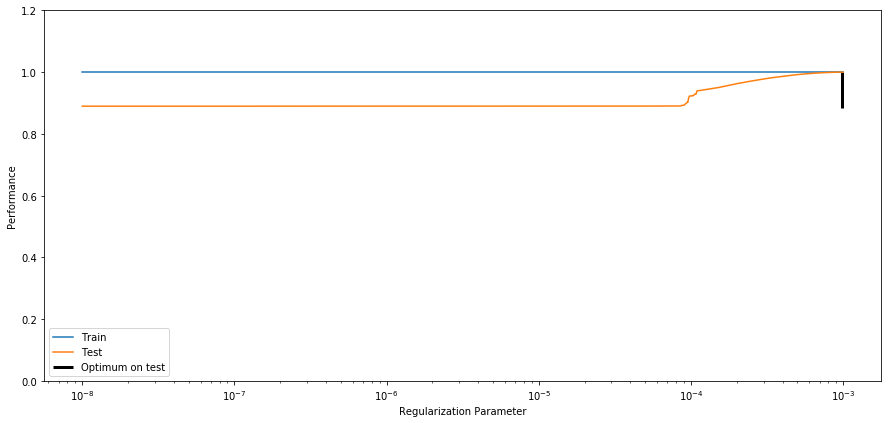

In [214]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

plt.figure(figsize=(15,15))
plt.subplot(2, 1, 1)

# Fill these in
alphas = alpha_range
train_errors = train_errors
test_errors = R2
alpha_optim = alpha

plt.semilogx(alphas, train_errors, label='Train')
plt.semilogx(alphas, test_errors, label='Test')
plt.vlines(alpha_optim, plt.ylim()[0], np.max(test_errors), color='k',
           linewidth=3, label='Optimum on test')
plt.legend(loc='lower left')
plt.ylim([0, 1.2])
plt.xlabel('Regularization Parameter')
plt.ylabel('Performance')

plt.show()

The plot above also shows the optimum regularization parameter of around 0.00099.

e) Plot the top coefficients based on this optimal parameter. Why do you think so many are zero? 

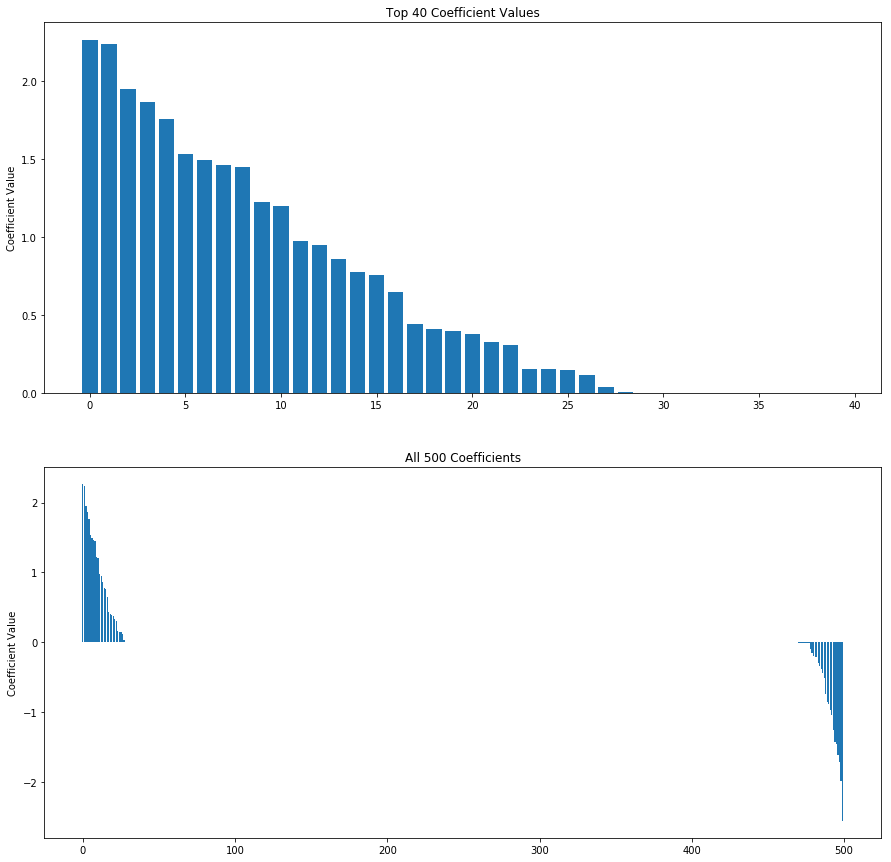

In [215]:
regr = Lasso(alpha_optim)
regr.fit(X_train, y_train)
regr.coef_
coefficients = sorted(regr.coef_, reverse=True)

plt.figure(figsize=(15,15))

plt.subplot(2,1,1)
plt.bar(np.arange(0,40,1), coefficients[0:40])
plt.ylabel('Coefficient Value')
plt.title('Top 40 Coefficient Values')

plt.subplot(2,1,2)
plt.bar(np.arange(0,500,1), coefficients)
plt.ylabel('Coefficient Value')
plt.title('All 500 Coefficients')

plt.show()

As can be seen above, of the 500 coefficients, the majority have a value of zero. This is because Lasso regression yields a sparse model that only involve a subset of the variables. The $L^1$ penalty in Lasso regression forces a number of the coefficient estimates to be exactly zero when the tuning parameter is sufficiently large.

f) Compute the $R^2$ with the optimal coefficient found above on 5 folds using cross_val_score and plot the
results. Does the model work well on all random subsets?

R^2 for 5 Folds: [ 0.99999247  0.999997    0.99999728  0.99999433  0.99998968]


<Container object of 5 artists>

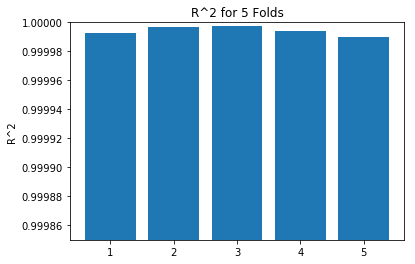

In [228]:
from sklearn.model_selection import cross_val_score

print("R^2 for 5 Folds: " + str(cross_val_score(regr, X, y, cv=5)))

plt.ylim([0.99985,1.0000])
plt.title("R^2 for 5 Folds")
plt.ylabel("R^2")
plt.bar(np.arange(1,6,1),cross_val_score(regr, X, y, cv=5))

In all five cases, the $R^2$ value is very close to 1. This suggests that the model would work well on all random subsets. However, because they are so close to 1, we should also be careful of the potential that the model is overfitting. Ideally, we would be able to test on new data if available.

g) Repeat e) but using cross validation. Use error bars on the features which are the standard deviation of the 
coefficients obtained above. For this problem I'll walk you through the code. You just need to apply your optimal
$\alpha$ found above. 

In [232]:
from sklearn.cross_validation import KFold
from sklearn import preprocessing
def run_cv_coeffs(X,y,clf_class,**kwargs):
    # Construct a kfolds object
    kf = KFold(len(y),n_folds=5,shuffle=True)
    y_pred = y.copy()
    coeffs=[]
    # Iterate through folds
    for train_index, test_index in kf:
        
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        # Initialize a classifier with key word arguments
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        y_pred[test_index] = clf.predict(X_test)
        coeffs.append(clf.coef_)
    return coeffs



scaler = preprocessing.StandardScaler()
X_scaled = X.as_matrix().astype(np.float)
X_scaled = scaler.fit_transform(X)

coeffs=run_cv_coeffs(X_scaled,np.array(y),Lasso,alpha=alpha_optim)

C:\Users\iantf\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


In [233]:
def get_coeffs(coeffs):
    coeffs_avgd = [(coeffs[0][i] + coeffs[1][i] + coeffs[2][i] + coeffs[3][i] + coeffs[4][i])/5 for i in range(0,len(X.columns))]
    coeffs_std = [np.std([coeffs[0][i],coeffs[1][i],coeffs[2][i],coeffs[3][i],coeffs[4][i]]) for i in range(0,len(X.columns))]
    return coeffs_avgd, coeffs_std
coeffs_avg,coeffs_std=get_coeffs(coeffs)

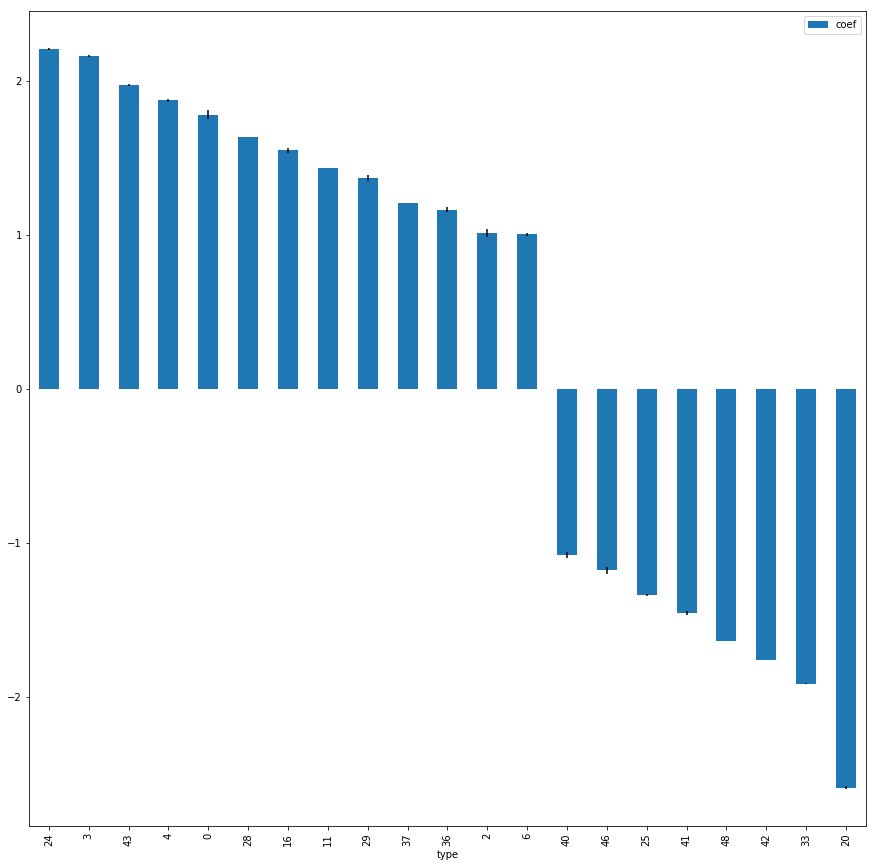

In [234]:
dfCoeffs = pd.DataFrame({'type':X.columns.values, 'coef':coeffs_avg, 'std':coeffs_std})
dfCoeffs = dfCoeffs[(dfCoeffs['coef']>1) |(dfCoeffs['coef']<-1) ]
plt.figure(figsize=(15,15))
dfCoeffs_sorted = dfCoeffs.sort_values(['coef'])[::-1]
yerr_vals = dfCoeffs_sorted['std'].values
dfCoeffs_sorted.plot(x='type',y='coef',kind='bar',yerr=yerr_vals,figsize=(15,15))